In [1]:
# from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
import torch
torch.manual_seed(0)
import torch.distributions as dist
import matplotlib.pyplot as plt
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Comment the statement below if not running on colab

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Change the file path below, so that it points to the required directory

In [3]:
def results(x,y):
#     print(x,y)
    if x>y:
        return 1
    elif x<y:
        return -1
    else:
        return 0
# epl_1718 = pd.read_csv("DataCLEANED.csv")
'''
1: Home Win
-1: Away WIn
0: Draw
'''
epl_1718 = pd.read_csv("/content/gdrive/MyDrive/NLP_project/senti_data.tsv", sep="\t")
# epl_1718["Season"] = epl_1718["Season"].str.split("/", expand=True)[1]
# epl_1718["Result"] = epl_1718.apply(lambda x: results(x["FTHG"], x["FTAG"]), axis=1)
epl_1718 = epl_1718[['HomeTeam','AwayTeam','HomeGoals','AwayGoals', 'Date', "Season", "sentiment", "Result"]]
# epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1718.tail()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result
1293,Manchester United,Watford,1,0,13/05/2018,18,"-0.000351637601852417,0",1
1294,Newcastle United,Chelsea,3,0,13/05/2018,18,"-0.9842156916856766,0.9160513877868652",1
1295,Southampton,Manchester City,0,1,13/05/2018,18,"0.9962852895259857,0.3730456630388896",-1
1296,Swansea City,Stoke City,1,2,13/05/2018,18,"0.9779690504074097,0.005281955003738403",-1
1297,West Ham United,Everton,3,1,13/05/2018,18,"0,-0.24474820494651794",1


In [4]:
teams = epl_1718.HomeTeam.unique()
teams.sort()
team_code = np.arange(epl_1718.HomeTeam.unique().shape[0])
team_dict = {}
for i in team_code:
    team_dict[teams[i]] = i
# l = torch.ones((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True) #home attack, home defense, away attack, away defense
l = torch.rand((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True)
# l_factor = 0.2*l
p = torch.tensor(0.01, requires_grad = True)
losses = []



In [5]:
def get_independence_factor(x,y, l, u, p):
#     print(x,y)
    if x==0 and y==0:
        t = 1-(l*u*p)
    elif x==0 and y==1:
        t = 1+(l*p)
    elif x==1 and y==0:
        t = 1+(u*p)
    elif x==1 and y==1:
        t = 1-p
    else:
        t = torch.tensor(1.0, requires_grad=True)
#     print("t: ",t)
    return(t)



def get_date_diff(dt1,dt2):
    d1_str, m1_str, y1_str = dt1.split('/')
    d1, m1, y1 = int(d1_str), int(m1_str), int(y1_str)
    d2_str, m2_str, y2_str = dt2.split('/')
    d2, m2, y2 = int(d2_str), int(m2_str), int(y2_str)

    diff = 12*(y1-y2)+((m1-m2))+(d1-d2)/30.5
#     diff = d1 - d2
    return(diff)
#     print(m1, m2, y1, y2, diff)

get_date_diff("2/12/2018", "2/01/2003")

191.0

In [6]:
l_t = torch.rand((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True)
# l_factor = 0.2*l
p_t = torch.tensor(0.01, requires_grad = True)
# s_t = torch.tensor(0.00, requires_grad = False)
e_t = torch.tensor(0.08, requires_grad = False)
losses_t = []
train_acc = []
test_acc = []

In [7]:
# classifier = pipeline("zero-shot-classification")
# sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

In [8]:
global index_cnt
index_cnt=0
def get_senti_para(ht, at, commentary):
  sequence =  commentary.split('.')
  # candidate_labels = ["Arsenal", "Sunderland"]
  senti = {
      ht:0,
      at:0
  }
  cnt = {
      ht:0,
      at:0
  }
  try:
    for s in sequence:
      a = classifier(s, [ht, at])
      if 100*abs(a['scores'][1]-a['scores'][0])>15:
        team = a['labels'][0]
        lsenti = sentiment_pipeline(a['sequence'])[0]
        prob = lsenti['score']
        tag = 1 if lsenti['label']=='POSITIVE' else -1
        prob *= tag
        senti[team] += prob
        cnt[team] +=1
        print(a['labels'][0], a['sequence'], prob, lsenti)
    if cnt[ht]!=0:
      senti_ht = senti[ht]/cnt[ht]
    else:
      senti_ht = 0
    
    if cnt[at]!=0:
      senti_at = senti[at]/cnt[at]
    else:
      senti_at = 0
    prob = str(senti_ht)+','+str(senti_at)
    # print(index_cnt, prob)
    return(prob)
  except:
    return('0,0')

In [9]:
#Train and test split
test_data = epl_1718[epl_1718["Season"]==18]
train = epl_1718[epl_1718["Season"]!=18]
# display(train)
max_date = train['Date'].iloc[-1]
train["tdiff"] = train.apply(lambda row: get_date_diff(max_date,row.Date), axis=1)
print(train['Date'].max(), train['Date'].min())
print(train.shape, test_data.shape)

# train = train.to(DEVICE)
# test_data = test_data.to(DEVICE)
display(train.head(5))
display(train.tail(5))

display(train.groupby("Result").size())

31/12/2016 01/04/2017
(1021, 9) (277, 8)


<ipython-input-9-4e6cf52fbee4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["tdiff"] = train.apply(lambda row: get_date_diff(max_date,row.Date), axis=1)


,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff
0,Arsenal,Sunderland,4,1,22/02/2014,14,"-0.9547230005264282,0.3173554340998332",1,38.967213
1,Chelsea,Everton,1,0,22/02/2014,14,"0.9953464865684509,0.02847188711166382",1,38.967213
2,Crystal Palace,Manchester United,0,2,22/02/2014,14,"0.9969965020815531,-0.9977181553840637",-1,38.967213
3,Manchester City,Stoke City,1,0,22/02/2014,14,"0.9937049746513367,0.8850798606872559",1,38.967213
4,West Brom,Fulham,1,1,22/02/2014,14,"-0.9992745518684387,-0.003087550401687622",0,38.967213


,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff
1016,Liverpool,Middlesbrough,3,0,21/05/2017,17,"-0.3118300239245097,0.9976814985275269",1,0.0
1017,Manchester United,Crystal Palace,2,0,21/05/2017,17,"-0.9788022041320801,-0.9966076612472534",1,0.0
1018,Southampton,Stoke City,0,1,21/05/2017,17,"-0.11586630344390869,-0.9954695701599121",-1,0.0
1019,Swansea City,West Brom,2,1,21/05/2017,17,"0.999483585357666,0.0016651451587677002",1,0.0
1020,Watford,Manchester City,0,5,21/05/2017,17,"-0.3273695707321167,-0.9993119239807129",-1,0.0


Result
-1    316
 0    235
 1    470
dtype: int64

In [10]:
# epl_1718.to_csv('/content/gdrive/MyDrive/NLP_project/example.tsv', sep="\t")

In [11]:
display(epl_1718.head(5))

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result
0,Arsenal,Sunderland,4,1,22/02/2014,14,"-0.9547230005264282,0.3173554340998332",1
1,Chelsea,Everton,1,0,22/02/2014,14,"0.9953464865684509,0.02847188711166382",1
2,Crystal Palace,Manchester United,0,2,22/02/2014,14,"0.9969965020815531,-0.9977181553840637",-1
3,Manchester City,Stoke City,1,0,22/02/2014,14,"0.9937049746513367,0.8850798606872559",1
4,West Brom,Fulham,1,1,22/02/2014,14,"-0.9992745518684387,-0.003087550401687622",0


In [12]:
def get_independence_factor_test(x,y, l, u, p):
#     print(x,y)
    t=[]
    for i in range(len(x)):
        if x[i]==0 and y[i]==0:
            a= 1-(l*u*p)
        elif x[i]==0 and y[i]==1:
            a= 1+(l*p)
        elif x[i]==1 and y[i]==0:
            a= 1+(u*p)
        elif x[i]==1 and y[i]==1:
            a= 1-p
        else:
            a= torch.tensor(1)
        t.append(a.item())
    return(t)


def predict_prob(l, p, home_team, away_team, home_goal, away_goal):
    lm = torch.exp(l[team_dict[home_team],0]+l[team_dict[away_team],1]+l[team_dict[home_team],2])#+s*ht_senti)
    um = torch.exp(l[team_dict[away_team],0]+l[team_dict[home_team],1])#+s*at_senti)
    x =  home_goal
    y =  away_goal
    p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
    p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
    if p< p_lower:
        p = p_lower
    elif p>p_upper:
        p = p_upper
    t_e = [get_independence_factor_test(x[i],y[i], lm, um, p) for i in range(len(x))]
    t = torch.log(torch.tensor(np.array(t_e)))      
    home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
    away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
    prob = t+home_prob+away_prob    
    return(prob)


def test(l, p, home_team, away_team,  plot=False):
    xx, yy = np.meshgrid(np.arange(0,6,1), np.arange(0,6,1))
    # with torch.no_grad:
    tensor_zz = predict_prob(l, p, home_team, away_team, xx, yy)
    zz = tensor_zz.detach().numpy()
    i = np.unravel_index(np.argmax(zz), zz.shape)
    
    no_ndiag_ele = 0.5*((tensor_zz.shape[0]**2)-tensor_zz.shape[0])
    p_w = torch.sum(torch.triu(torch.exp(tensor_zz)))/no_ndiag_ele
    p_l = torch.sum(torch.tril(torch.exp(tensor_zz)))/no_ndiag_ele
    p_d = torch.sum(torch.diag(torch.exp(tensor_zz)))/tensor_zz.shape[0]
#     print(p_w, p_l, p_d)
    s = (p_w+p_l+p_d)
    p_w /= s
    p_l /= s
    p_d /= s
#     print(p_w, p_l, p_d)
    res = torch.argmax(torch.tensor((p_l, p_d, p_w)))-1
#     if res==1:
#         res_prob = p_w
#     elif res==-1:
#         res_prob = p_w
#     elif res==0:
#         res_prob = p_d
    if plot:
        print("P h win: %0.3f, P draw: %0.3f, P a w: %0.3f"%(p_w.item(), p_d.item(), p_l.item()))
        print("Highest probability Goal Summary\nHome Team %s: %d,\nAway Team %s: %d"%(home_team, xx[i], away_team, yy[i]))
        fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
        cp1 = ax1.contourf(xx, yy, zz)
        fig.colorbar(cp1) # Add a colorbar to a plot
        ax1.set_title('Log Prob plot')
        ax1.set_xlabel('x (goals)')
        ax1.set_ylabel('y (goals)')

        cp2 = ax2.contourf(xx, yy, np.exp(zz))
        fig.colorbar(cp2) # Add a colorbar to a plot
        ax2.set_title('Prob plot')
        ax2.set_xlabel('x (goals)')
        ax2.set_ylabel('y (goals)')

        plt.show()
    return(res, (p_w, p_d, p_l), results(xx[i],yy[i]))



def calc_loss_results(l, p, e, data, test_data, team_dict):
    loss = torch.tensor(0.0)
    train_pred = 0
    phw = 0
    paw = 0
    p_d = 0
    for index, row in data.iterrows():
        # ht_senti, at_senti = float(row.sentiment.split(',')[0]), float(row.sentiment.split(',')[1])
        lm = torch.exp(l[team_dict[row["HomeTeam"]],0]+l[team_dict[row["AwayTeam"]],1]+l[team_dict[row["HomeTeam"]],2])#+s*ht_senti)
        um = torch.exp(l[team_dict[row["AwayTeam"]],0]+l[team_dict[row["HomeTeam"]],1])#+s*at_senti)
        x =  row["HomeGoals"]
        y =  row["AwayGoals"]
        tdiff = row["tdiff"]
        p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
        p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
        if p< p_lower:
            p = p_lower
        elif p>p_upper:
            p = p_upper
        t = torch.log(get_independence_factor(x,y, lm, um, p))             
        home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
        away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
        loss += torch.exp(-e*tdiff)*(t + home_prob + away_prob)
        
        res1, res_prob, res2 = test(l, p, row["HomeTeam"], row["AwayTeam"], plot=False)
        train_pred += float(res1==row["Result"])
        
        if row["Result"]==1:
            phw += res_prob[0]
        elif row["Result"]==-1:
            paw += res_prob[2]
        else:
            p_d += res_prob[1]    
        
#     loss = torch.log(phw)+torch.log(paw)+torch.log(p_d)
#     test_pred = calc_test_accuracy(l_t, p_t, test_data, row["HomeTeam"], row["AwayTeam"])
    train_pred /= data.shape[0]
    test_pred = 0
    
    return(-loss, train_pred, test_pred)
print("LOSS: ",calc_loss_results(l_t, p_t, e_t, train, test_data, team_dict))

LOSS:  (tensor(1441.6139, grad_fn=<NegBackward0>), 0.4622918707149853, 0)


In [13]:
def run_train(l_t, p_t, e_t, train, test_data, team_dict, no_of_iter = 50, debug_msg=True):
    optimizer = torch.optim.Adagrad([l_t,p_t, e_t], lr = 0.1)
#     no_of_iter = 80
    no_of_teams = l_t.shape[0]
    for i in range(no_of_iter):
    #     l_cpy = l
        sum_loss = torch.sqrt((1-((1/no_of_teams)*torch.sum(torch.exp(l_t[:,0]))))**2)
        loss, train_accuracy, test_accuracy = calc_loss_results(l_t, p_t, e_t, train, test_data, team_dict) #+(0.05*sum_loss)

        if debug_msg:
            print("iter: %d, Loss: %0.3f, sum loss: %0.3f, train acc: %0.3f, test acc: %0.3f"%(i, loss, sum_loss, train_accuracy, test_accuracy))
        losses_t.append(loss.item())
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
#     print(torch.sum(torch.exp(l[:,0])))

run_train(l_t, p_t, e_t, train, test_data, team_dict, no_of_iter=80, debug_msg=True)   

iter: 0, Loss: 1441.614, sum loss: 0.676, train acc: 0.462, test acc: 0.000
iter: 1, Loss: 1215.840, sum loss: 0.541, train acc: 0.474, test acc: 0.000
iter: 2, Loss: 1140.055, sum loss: 0.479, train acc: 0.480, test acc: 0.000
iter: 3, Loss: 1099.892, sum loss: 0.445, train acc: 0.477, test acc: 0.000
iter: 4, Loss: 1074.646, sum loss: 0.415, train acc: 0.486, test acc: 0.000
iter: 5, Loss: 1057.207, sum loss: 0.394, train acc: 0.491, test acc: 0.000
iter: 6, Loss: 1044.401, sum loss: 0.376, train acc: 0.500, test acc: 0.000
iter: 7, Loss: 1034.577, sum loss: 0.361, train acc: 0.499, test acc: 0.000
iter: 8, Loss: 1026.790, sum loss: 0.349, train acc: 0.504, test acc: 0.000
iter: 9, Loss: 1020.460, sum loss: 0.339, train acc: 0.501, test acc: 0.000
iter: 10, Loss: 1015.208, sum loss: 0.330, train acc: 0.506, test acc: 0.000
iter: 11, Loss: 1010.781, sum loss: 0.322, train acc: 0.509, test acc: 0.000
iter: 12, Loss: 1006.997, sum loss: 0.315, train acc: 0.512, test acc: 0.000
iter: 13,

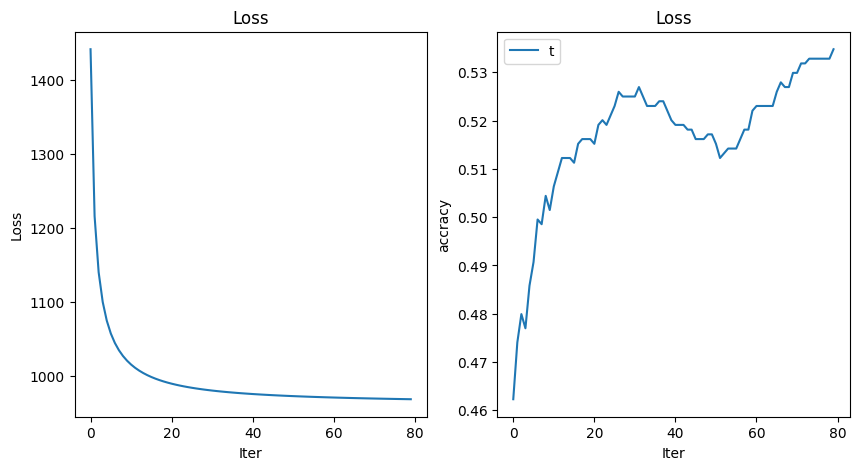

In [14]:
x = np.arange(len(losses_t))
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
cp1 = ax1.plot(x, losses_t)
ax1.set_title('Loss')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Loss')

ax2.plot(x, train_acc)
# ax2.plot(x, test_acc)
ax2.set_title('Loss')
ax2.set_xlabel('Iter')
ax2.set_ylabel('accracy')
ax2.legend(("train acc"))
plt.show()



In [15]:
for i in team_dict.keys():
    print(i,"\t",[float("{:.3f}".format(np.exp(x.item()))) for x in l_t[team_dict[i],:]], "\t",[float("{:.3f}".format(x.item())) for x in l_t[team_dict[i],:]])
print("Rho: ", float("{:.3f}".format(p_t.item())))
print("e: ", float("{:.3f}".format(e_t.item())))
# print("s: ", float("{:.3f}".format(s_t.item())))


Arsenal 	 [1.772, 0.91, 1.145] 	 [0.572, -0.094, 0.136]
Aston Villa 	 [0.77, 1.402, 0.946] 	 [-0.262, 0.338, -0.056]
Bournemouth 	 [1.143, 1.37, 1.502] 	 [0.134, 0.315, 0.407]
Brighton 	 [1.988, 1.005, 1.192] 	 [0.687, 0.005, 0.176]
Burnley 	 [1.003, 1.125, 1.169] 	 [0.003, 0.118, 0.156]
Cardiff 	 [1.0, 1.147, 1.868] 	 [0.0, 0.137, 0.625]
Chelsea 	 [1.601, 0.752, 1.446] 	 [0.471, -0.285, 0.369]
Crystal Palace 	 [1.238, 1.204, 0.976] 	 [0.213, 0.186, -0.024]
Everton 	 [1.077, 0.935, 1.86] 	 [0.074, -0.067, 0.62]
Fulham 	 [1.095, 1.606, 1.246] 	 [0.091, 0.474, 0.22]
Huddersfield 	 [2.323, 1.082, 1.456] 	 [0.843, 0.078, 0.376]
Hull City 	 [0.799, 1.57, 1.406] 	 [-0.224, 0.451, 0.341]
Leicester City 	 [1.306, 1.091, 1.232] 	 [0.267, 0.087, 0.208]
Liverpool 	 [1.587, 0.904, 1.201] 	 [0.462, -0.1, 0.183]
Manchester City 	 [1.929, 0.81, 1.122] 	 [0.657, -0.21, 0.115]
Manchester United 	 [1.331, 0.699, 1.14] 	 [0.286, -0.358, 0.131]
Middlesbrough 	 [0.583, 1.026, 1.465] 	 [-0.539, 0.026, 0.382

In [16]:
train["PredResult"] = train.apply(lambda x: test(l_t, p_t, x["HomeTeam"], x["AwayTeam"],  plot=False)[0].item(), axis=1)
train["PredProb"] = train.apply(lambda x: [i.item() for i in test(l_t, p_t, x["HomeTeam"], x["AwayTeam"],  plot=False)[1]], axis=1)

<ipython-input-16-c7d39c2a5a96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["PredResult"] = train.apply(lambda x: test(l_t, p_t, x["HomeTeam"], x["AwayTeam"],  plot=False)[0].item(), axis=1)
<ipython-input-16-c7d39c2a5a96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["PredProb"] = train.apply(lambda x: [i.item() for i in test(l_t, p_t, x["HomeTeam"], x["AwayTeam"],  plot=False)[1]], axis=1)


In [17]:
train.head(5)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff,PredResult,PredProb
0,Arsenal,Sunderland,4,1,22/02/2014,14,"-0.9547230005264282,0.3173554340998332",1,38.967213,1,"[0.5916792480933932, 0.24888957299323158, 0.15..."
1,Chelsea,Everton,1,0,22/02/2014,14,"0.9953464865684509,0.02847188711166382",1,38.967213,1,"[0.5170289278459744, 0.2902838288741893, 0.192..."
2,Crystal Palace,Manchester United,0,2,22/02/2014,14,"0.9969965020815531,-0.9977181553840637",-1,38.967213,-1,"[0.23868364487023308, 0.33669159496563444, 0.4..."
3,Manchester City,Stoke City,1,0,22/02/2014,14,"0.9937049746513367,0.8850798606872559",1,38.967213,1,"[0.5493102916613913, 0.27248420980864574, 0.17..."
4,West Brom,Fulham,1,1,22/02/2014,14,"-0.9992745518684387,-0.003087550401687622",0,38.967213,1,"[0.4338262750355575, 0.319258393298282, 0.2469..."


Simulating match type scenario.
The model is fine tuned after each game for better prediction accuracy. Please note, this section is a game simulation in a time series fashion and can take 3 hrs to run on the entire tournament. Currently the call function is commented out, to ensure smooth run, but if in case planning to run, please uncomment that statement.

In [18]:
simulate_accuracy = []
def simulate_match(l_t, p_t, e_t, train, test_data, team_dict):
    # train_local = pd.DataFrame(columns = train.columns)
    train_local = train.copy()
    l = len(train_local)
    print(len(test_data))
    acc = 0
    match = 0
    
#     display(train_local.tail(5))
    for i, row in test_data.iterrows():
        print(i)
        res1, prob, res2 = test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)
        match +=1
        row["PredResult"] = res1.item()
        row["PredProb"] = [i.item() for i in prob]
        train_local.loc[i+l] = row
        max_date = train_local['Date'].iloc[-1]
        train_local["tdiff"] = train_local.apply(lambda row: get_date_diff(max_date,row.Date), axis=1)
        if res1==row["Result"]:
            acc += 1  
            simulate_accuracy.append(acc/match)
            print(match," test_pred: ", acc/match, "acc: ", acc, "match: ", match)
            continue
            
        simulate_accuracy.append(acc/match)
        print(match," test_pred: ", acc/match, "acc: ", acc, "match: ", match)
        run_train(l_t, p_t, e_t, train_local, test_data, team_dict, no_of_iter = 30, debug_msg=False)

        
    display(train_local.tail(15))
    print(train_local.shape)
    return(train_local)

# full_pred_data = simulate_match(l_t, p_t, e_t, train, test_data, team_dict)
# full_pred_data.to_csv('/content/gdrive/MyDrive/NLP_project/pred_output_dixcon_coles.tsv', sep="\t")

277
1021
1  test_pred:  1.0 acc:  1 match:  1
1022
2  test_pred:  1.0 acc:  2 match:  2
1023
3  test_pred:  0.6666666666666666 acc:  2 match:  3
1024
4  test_pred:  0.75 acc:  3 match:  4
1025
5  test_pred:  0.6 acc:  3 match:  5
1026
6  test_pred:  0.5 acc:  3 match:  6
1027
7  test_pred:  0.5714285714285714 acc:  4 match:  7
1028
8  test_pred:  0.625 acc:  5 match:  8
1029
9  test_pred:  0.6666666666666666 acc:  6 match:  9
1030
10  test_pred:  0.6 acc:  6 match:  10
1031
11  test_pred:  0.5454545454545454 acc:  6 match:  11
1032
12  test_pred:  0.5833333333333334 acc:  7 match:  12
1033
13  test_pred:  0.6153846153846154 acc:  8 match:  13
1034
14  test_pred:  0.6428571428571429 acc:  9 match:  14
1035
15  test_pred:  0.6 acc:  9 match:  15
1036
16  test_pred:  0.625 acc:  10 match:  16
1037
17  test_pred:  0.5882352941176471 acc:  10 match:  17
1038
18  test_pred:  0.5555555555555556 acc:  10 match:  18
1039
19  test_pred:  0.5789473684210527 acc:  11 match:  19
1040
20  test_pred:

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff,PredResult,PredProb
2304,Everton,Southampton,1,1,05/05/2018,18,"0.9546822508176168,-0.054110437631607056",0,0.262295,1,"[0.37776703558644326, 0.34385553202677527, 0.2..."
2305,Leicester City,West Ham United,0,2,05/05/2018,18,"0.04248914122581482,0.009689658880233765",-1,0.262295,1,"[0.3748234217498701, 0.3298361814318685, 0.295..."
2306,Stoke City,Crystal Palace,1,2,05/05/2018,18,"0.9696972370147705,0.9995821118354797",-1,0.262295,0,"[0.34829191063639797, 0.3580786987306557, 0.29..."
2307,Watford,Newcastle United,2,1,05/05/2018,18,"0.36068397760391235,-0.9893472194671631",1,0.262295,0,"[0.3435986167767986, 0.35926015716778387, 0.29..."
2308,West Brom,Tottenham Hotspur,1,0,05/05/2018,18,"-0.9776820540428162,0.9845466017723083",1,0.262295,-1,"[0.20238158693558744, 0.3181381445017147, 0.47..."
2309,Arsenal,Burnley,5,0,06/05/2018,18,"0.9609211484591166,-0.9988335967063904",1,0.229508,1,"[0.4679220392472947, 0.3204995427987973, 0.211..."
2310,Chelsea,Liverpool,1,0,06/05/2018,18,"0.8995910882949829,-0.04312315583229065",1,0.229508,1,"[0.3765700840440347, 0.3404524054327785, 0.282..."
2311,Burnley,Bournemouth,1,2,13/05/2018,18,"0.2951050400733948,0",-1,0.000000,1,"[0.38581902842908666, 0.3726381703154804, 0.24..."
2312,Crystal Palace,West Brom,2,0,13/05/2018,18,"0.9996730089187622,0",1,0.000000,1,"[0.42072204679443315, 0.34794653895923644, 0.2..."
2313,Liverpool,Brighton,4,0,13/05/2018,18,"0.33354928096135456,0.9996480941772461",1,0.000000,1,"[0.5968938862432601, 0.2667814903301198, 0.136..."


(1298, 11)


In [19]:
full_pred_data.tail(5)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff,PredResult,PredProb
2314,Manchester United,Watford,1,0,13/05/2018,18,"-0.000351637601852417,0",1,0.0,1,"[0.5904256544382257, 0.2659076669858117, 0.143..."
2315,Newcastle United,Chelsea,3,0,13/05/2018,18,"-0.9842156916856766,0.9160513877868652",1,0.0,-1,"[0.2136911078260417, 0.3385708655586806, 0.447..."
2316,Southampton,Manchester City,0,1,13/05/2018,18,"0.9962852895259857,0.3730456630388896",-1,0.0,-1,"[0.19839570170709764, 0.29878382669351256, 0.5..."
2317,Swansea City,Stoke City,1,2,13/05/2018,18,"0.9779690504074097,0.005281955003738403",-1,0.0,1,"[0.3683991053150824, 0.36380005303224755, 0.26..."
2318,West Ham United,Everton,3,1,13/05/2018,18,"0,-0.24474820494651794",1,0.0,0,"[0.33587572071245403, 0.35090548712628084, 0.3..."


In [20]:
# full_pred_data.to_csv('/content/gdrive/MyDrive/NLP_project/pred_output_dixcon_coles.tsv', sep="\t")

avg accuracy:  0.5320118062582355


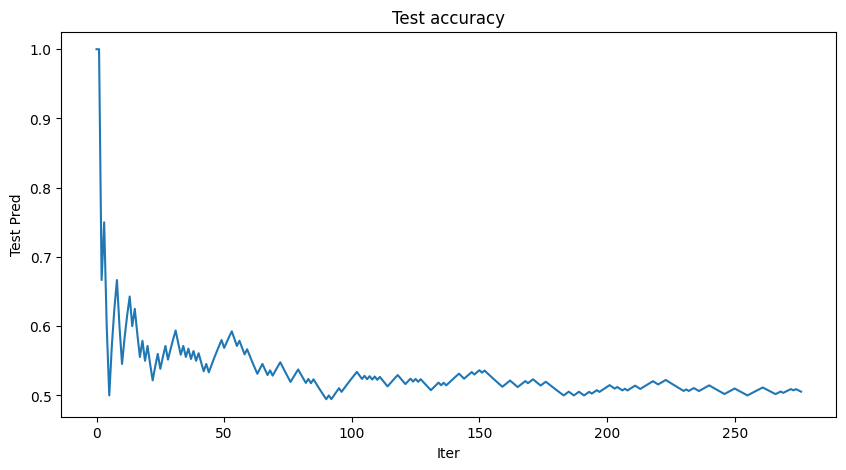

In [21]:
x = np.arange(len(simulate_accuracy))
fig, ax1=plt.subplots(1,1,figsize=(10, 5))
cp1 = ax1.plot(x, simulate_accuracy)
ax1.set_title('Test accuracy')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Test Pred')
print("avg accuracy: ", np.mean(np.array(simulate_accuracy)))

plt.show()

In [22]:
def get_test_accuracy(l_t, p_t, e_t, train, test_data, team_dict):
    train_local = pd.DataFrame(columns = train.columns)
    acc = 0
    match = 0
#     display(train_local.tail(5))
    for i, row in test_data.iterrows():
        ht_senti, at_senti = float(row.sentiment.split(',')[0]), float(row.sentiment.split(',')[1])
        res1, prob, res2 = test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)
        match +=1
        if res1==row["Result"]:
            acc += 1     
        
        train_local.loc[i] = row
#         train_local.loc[i,"tdiff"] = 0.5
        print(match," test_pred: ", acc/match, "acc: ", acc, "match: ", match)
    display(train_local.tail(5))
    print(train_local.shape)

get_test_accuracy(l_t, p_t, e_t, train, test_data, team_dict)

for i in team_dict.keys():
    print(i,"\t",[float("{:.3f}".format(np.exp(x.item()))) for x in l_t[team_dict[i],:]], "\t",[float("{:.3f}".format(x.item())) for x in l_t[team_dict[i],:]])
print("Rho: ", float("{:.3f}".format(p_t.item())))
print("e: ", float("{:.3f}".format(e_t.item())))


1  test_pred:  1.0 acc:  1 match:  1
2  test_pred:  1.0 acc:  2 match:  2
3  test_pred:  0.6666666666666666 acc:  2 match:  3
4  test_pred:  0.75 acc:  3 match:  4
5  test_pred:  0.6 acc:  3 match:  5
6  test_pred:  0.5 acc:  3 match:  6
7  test_pred:  0.5714285714285714 acc:  4 match:  7
8  test_pred:  0.625 acc:  5 match:  8
9  test_pred:  0.6666666666666666 acc:  6 match:  9
10  test_pred:  0.6 acc:  6 match:  10
11  test_pred:  0.5454545454545454 acc:  6 match:  11
12  test_pred:  0.5833333333333334 acc:  7 match:  12
13  test_pred:  0.6153846153846154 acc:  8 match:  13
14  test_pred:  0.6428571428571429 acc:  9 match:  14
15  test_pred:  0.6 acc:  9 match:  15
16  test_pred:  0.625 acc:  10 match:  16
17  test_pred:  0.5882352941176471 acc:  10 match:  17
18  test_pred:  0.5555555555555556 acc:  10 match:  18
19  test_pred:  0.5789473684210527 acc:  11 match:  19
20  test_pred:  0.55 acc:  11 match:  20
21  test_pred:  0.5714285714285714 acc:  12 match:  21
22  test_pred:  0.5909

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,sentiment,Result,tdiff,PredResult,PredProb
1293,Manchester United,Watford,1,0,13/05/2018,18,"-0.000351637601852417,0",1,NaN,NaN,NaN
1294,Newcastle United,Chelsea,3,0,13/05/2018,18,"-0.9842156916856766,0.9160513877868652",1,NaN,NaN,NaN
1295,Southampton,Manchester City,0,1,13/05/2018,18,"0.9962852895259857,0.3730456630388896",-1,NaN,NaN,NaN
1296,Swansea City,Stoke City,1,2,13/05/2018,18,"0.9779690504074097,0.005281955003738403",-1,NaN,NaN,NaN
1297,West Ham United,Everton,3,1,13/05/2018,18,"0,-0.24474820494651794",1,NaN,NaN,NaN


(277, 11)
Arsenal 	 [3.671, 0.353, 1.919] 	 [1.301, -1.042, 0.652]
Aston Villa 	 [1.886, 0.527, 1.091] 	 [0.635, -0.64, 0.087]
Bournemouth 	 [2.553, 0.491, 1.523] 	 [0.937, -0.712, 0.421]
Brighton 	 [1.015, 0.415, 3.761] 	 [0.015, -0.879, 1.325]
Burnley 	 [2.226, 0.331, 1.151] 	 [0.8, -1.107, 0.141]
Cardiff 	 [1.545, 0.332, 2.885] 	 [0.435, -1.102, 1.06]
Chelsea 	 [3.835, 0.276, 1.371] 	 [1.344, -1.289, 0.315]
Crystal Palace 	 [2.631, 0.413, 1.527] 	 [0.967, -0.883, 0.423]
Everton 	 [2.546, 0.418, 1.706] 	 [0.935, -0.872, 0.534]
Fulham 	 [3.013, 0.673, 1.037] 	 [1.103, -0.396, 0.036]
Huddersfield 	 [0.0, 0.363, 566394.704] 	 [-12.084, -1.014, 13.247]
Hull City 	 [1.276, 0.596, 2.706] 	 [0.244, -0.517, 0.996]
Leicester City 	 [3.707, 0.45, 0.919] 	 [1.31, -0.8, -0.085]
Liverpool 	 [4.516, 0.305, 1.293] 	 [1.508, -1.188, 0.257]
Manchester City 	 [5.752, 0.268, 1.393] 	 [1.75, -1.317, 0.331]
Manchester United 	 [4.227, 0.22, 1.087] 	 [1.441, -1.513, 0.083]
Middlesbrough 	 [0.953, 0.392, 2

P h win: 0.642, P draw: 0.228, P a w: 0.130
Highest probability Goal Summary
Home Team Arsenal: 2,
Away Team West Brom: 0


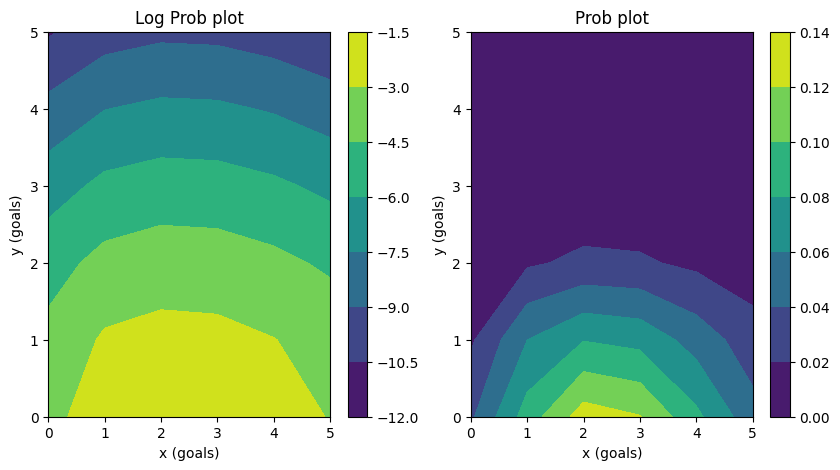

P h win: 0.284, P draw: 0.352, P a w: 0.364
Highest probability Goal Summary
Home Team West Brom: 1,
Away Team Arsenal: 1


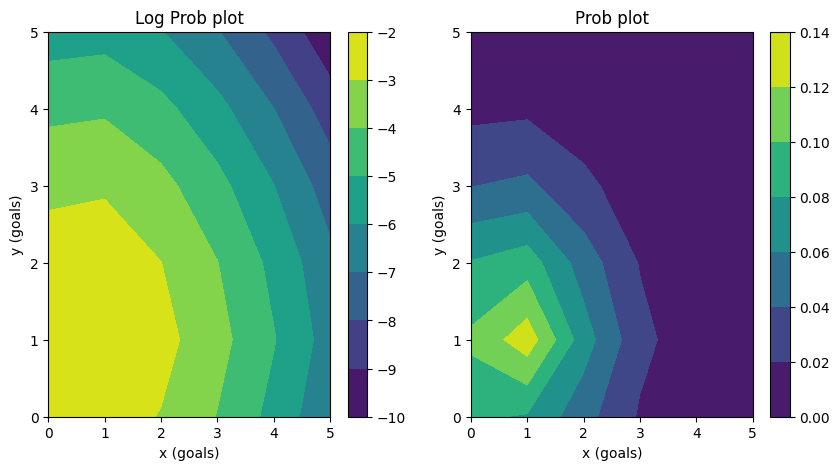

(tensor(-1),
 (tensor(0.2840, dtype=torch.float64, grad_fn=<DivBackward0>),
  tensor(0.3516, dtype=torch.float64, grad_fn=<DivBackward0>),
  tensor(0.3644, dtype=torch.float64, grad_fn=<DivBackward0>)),
 0)

In [23]:
test(l_t, p_t, "Arsenal","West Brom", plot=True)
test(l_t, p_t, "West Brom","Arsenal", plot=True)
